In [1]:
# STEP 1 #

# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
from sensor_msgs.msg import LaserScan
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid
from nav_msgs.msg import Path

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
import math

# declare the map resolution and scan variable
resolution = None
scan = None

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    # the map resolution
    global resolution
    resolution = float(recMap.info.resolution)
    # Return
    return recMap

def splitMap(map):
    """ Iterates over the map cells and add each to a corresponding list
        according to whether it is a wall or free space
        Arguments:
        map: OccupancyGrid, 
             header with metadata and a value for each pixel - 
             each a percentage chance of empty or occupied space.
    """
    # the arrays to hold the free and wall cells in the map
    global wallPositions
    wallPositions = None
    global freePositions
    freePositions = None

    # info from the OccupancyGrid
    mapData = np.array(map.data)
    mapInfo = map.info
    # convert the data to a 2d array (coordinates with occupancy certainty)
    map = np.split(mapData, map.info.width)
    
    # iteration counters serving as indices for the arrays
    x:int = 0 
    y:int = 0

    # nested loop to go through each cell
    # certainty of occupance is rated 0 - 100
    for row in map:
        for cell_occupancy in row:
            # convert the local map coordinated to global goordinates
            x_coord = x*mapInfo.resolution + mapInfo.origin.position.x + mapInfo.resolution/2
            y_coord = y*mapInfo.resolution + mapInfo.origin.position.y + mapInfo.resolution/2
            pos = np.array([[x_coord, y_coord]])
            if cell_occupancy == 0:
                # add to empty space list
                # if its the first element, initialize. Else, add the coords to the existing arr
                if freePositions is not None:
                    freePositions = np.vstack((freePositions, pos))
                else:
                    freePositions = pos
            else:
                # add to wall list
                if wallPositions is not None:
                    wallPositions = np.vstack((wallPositions, pos))
                else:
                    wallPositions = pos
            #increment the iteration counter for the cells in the row
            y += 1
        # reset the cell counter to the start and increment the row counter
        y = 0
        x += 1

def laserScanSubCallback(msg):
    """ Loads the laserscan from message """
    # check if the map has been received and read, else return until it has
    if resolution is None:
        return
        
    # arrange the angles evenly spaced between min and max values at
    angles = np.arange(msg.angle_min, msg.angle_max, msg.angle_increment)

    global scan
    # iterate over every range and angle pair and calculate the cartesian coordinates for each
    # ranges are adjusted to account for wall thickness
    for distance, angle in zip(msg.ranges, angles):
        x = math.sin(angle)*distance
        if x < 0:
            x = x - resolution/2
        elif x > 0:
            x = x + resolution/2
        y = math.cos(angle)*distance
        if y < 0:
            y = y - resolution/2
        elif y > 0:
            y = y + resolution/2
        pos = np.array([[x, y]])
        # if its the first element, initialize. Else, add the coords to the existing arr
        if scan is not None:
            scan = np.vstack((scan, pos))
        else:
            scan = pos

# create a ROS subscriber of the laserscan topic
laserScanSub = rospy.Subscriber("/scan", LaserScan, laserScanSubCallback)
# create a rOS publisher to publish the path to be vizualized in rviz
pathPub = rospy.Publisher("/myPath", Path, queue_size=1)

# Initiate ROS node
rospy.init_node('mazeEscape')
recMap = getMap()

# split the map into free and wall cells
splitMap(recMap)

# wait for the laserscan data to be received before plotting it
dump = rospy.wait_for_message("/scan", LaserScan, 9999999)

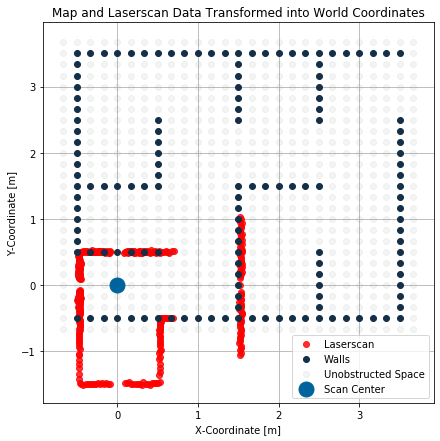

In [2]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")
ax.scatter([0], [0], c=colourScheme["twblue"], s=15**2, label="Scan Center")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map and Laserscan Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

In [3]:
# STEP 2 #

# Import kNN implementation
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# create an array to hold the value for every position on the map 1 == wall, 0 == free
y_wall = [1] * wallPositions.shape[0]
y_free = [0] * freePositions.shape[0]
y = np.hstack((y_wall, y_free))

# put all walls and free positions in one array
X = np.vstack((wallPositions, freePositions))

# create the classifier
clf = KNeighborsClassifier(n_neighbors=1, weights = "uniform")

# flip the x and y of the positions to be visualized correctly
X_flipped = X[:, ::-1]

# fit the classifier model
clf.fit(X_flipped, y)

KNeighborsClassifier(n_neighbors=1)

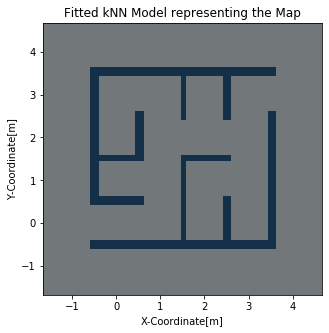

In [4]:
# Imports for visualisation
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

## Visualise fitted model using built-in visualiser
plt.rcParams['figure.figsize'] = [5, 5]
_, ax = plt.subplots()

DecisionBoundaryDisplay.from_estimator(
    clf,
    X_flipped,
    cmap=ListedColormap(
        [
            colourScheme["twgrey"],
            colourScheme["darkblue"]
        ]
    ),
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="X-Coordinate[m]",
    ylabel="Y-Coordinate[m]",
    shading="auto",
)

# Set title and show plot
ax.set_title("Fitted kNN Model representing the Map")
plt.show()

In [5]:
# Define the maze size
mazeX, mazeY = 4, 4

# Define possible robot positions on the grid
switched_positions = [(x, y) for x in range(mazeX) for y in range(mazeY)]
positions = [(y, x) for x, y in switched_positions]
# Function to transform the scan to the given position
def transform_scan(scan, position):
    """ Transposes the scan data to the desired position
        Arguments:
        scan: LaserScan
        position: (x, y)
    """
    # Move the scan to the new position
    transformed_scan = scan + position
    return transformed_scan

# flip the scan so that it can be flipped correctly later
scan_flipped = scan[:, ::-1]

# Transpose the scan at each possible position and predict the robots position probability as a score
scores = []
for position in switched_positions:
    transformed_scan = transform_scan(scan_flipped, position)
    # Predict if each point in the scan is a wall (1) or free space (0)
    predictions = clf.predict(transformed_scan)
    # Count the number of points predicted as walls
    score = np.sum(predictions == 1)
    scores.append(score)

# Normalize scores to range from 0 to 1 for better visualization
max_score = max(scores)
scores = [score / max_score for score in scores]

# define default robot position
robotPos = (0.0, 0.0)
# find the most likely robot position
for index, score in enumerate(scores):
    if score == 1.0:
        robotPos = positions[index]

In [6]:
import re

# Helper function for colours
# See https://matplotlib.org/stable/tutorials/colors/colormaps.html for more information
def createColourmapToWhite(rgb, reverse=True):
    """ Creates a colourmap that fades from rgb colour to white """
    # Unpack tuple and manually create fades with a resolution of 256
    r, g, b = rgb
    N = 256
    vals = np.ones((N, 4))
    # Distinguish between reverse and non-reverse and invert linspace accordingly
    if reverse:
        vals[:, 0] = np.linspace(1, r/N, N)
        vals[:, 1] = np.linspace(1, g/N, N)
        vals[:, 2] = np.linspace(1, b/N, N)
    else:
        vals[:, 0] = np.linspace(r/N, 1, N)
        vals[:, 1] = np.linspace(g/N, 1, N)
        vals[:, 2] = np.linspace(b/N, 1, N)
    return ListedColormap(vals)

def hexstring2rgb(colourstring):
    """ Converts hex colours in string form to rgb values """
    i = re.compile('#')
    colourstring = re.sub(i, '', colourstring)
    return tuple(int(colourstring[i:i+2], 16) for i in (0, 2, 4))

# Create colourmap that fades from white to UAS TW blue for heatmap
heatColourMap = createColourmapToWhite( hexstring2rgb( colourScheme["twblue"] ), reverse=True)

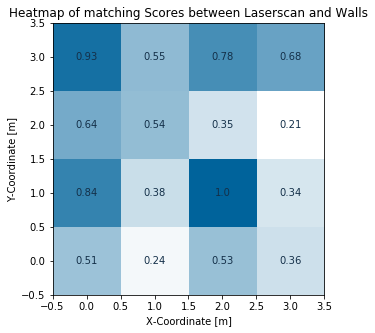

In [7]:
## Visualise scores as heatmap
# Create array holding the scores for imshow
scoreArr = np.zeros((mazeX, mazeY), dtype=np.float64)
for idx, val in zip(positions, scores): scoreArr[idx] = val

# Create figure and plot scores as heatmap
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
im = ax.imshow(scoreArr, cmap=heatColourMap, origin='lower')

# Create Text annotations of each cell
for i in range(mazeX):
    for j in range(mazeY):
        text = ax.text(j, i, "{:.2}".format(scoreArr[i, j]),
                       ha="center", va="center", color=colourScheme["darkblue"])

# Set title and axes descriptions
ax.set_title("Heatmap of matching Scores between Laserscan and Walls")
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")

# Show plot
plt.show()

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# manually define the edges
edges = [
    {'parent': '4.4', 'child': '10.4'},
    {'parent': '10.4', 'child': '10.10'},
    {'parent': '4.10', 'child': '10.10'},
    {'parent': '10.10', 'child': '10.16'},
    {'parent': '4.16', 'child': '4.22'},
    {'parent': '4.22', 'child': '10.22'},
    {'parent': '10.22', 'child': '10.16'},
    {'parent': '10.16', 'child': '16.16'},
    {'parent': '16.22', 'child': '16.16'},
    {'parent': '16.16', 'child': '22.16'},
    {'parent': '22.16', 'child': '22.22'},
    {'parent': '16.4', 'child': '16.10'},
    {'parent': '22.4', 'child': '22.10'},
    {'parent': '16.10', 'child': '22.10'},
    {'parent': '22.10', 'child': '22.16'}
]

# Function to convert node names to world coordinates
def fromNodeName(node_name, recMap):
    """ Transposes the scan data to the desired position
        Arguments:
        node_name: string
        recMap: OccupancyGrid
    """
    # split parent and child
    x_map, y_map = map(int, node_name.split('.'))
    # Convert map indices to world coordinates
    x_world = x_map * recMap.info.resolution + recMap.info.origin.position.x + recMap.info.resolution/2
    y_world = y_map * recMap.info.resolution + recMap.info.origin.position.y + recMap.info.resolution/2
    return np.array([x_world, y_world])  # Keep x and y in their original orientation

In [9]:
print(edges[:10])

[{'parent': '4.4', 'child': '10.4'}, {'parent': '10.4', 'child': '10.10'}, {'parent': '4.10', 'child': '10.10'}, {'parent': '10.10', 'child': '10.16'}, {'parent': '4.16', 'child': '4.22'}, {'parent': '4.22', 'child': '10.22'}, {'parent': '10.22', 'child': '10.16'}, {'parent': '10.16', 'child': '16.16'}, {'parent': '16.22', 'child': '16.16'}, {'parent': '16.16', 'child': '22.16'}]


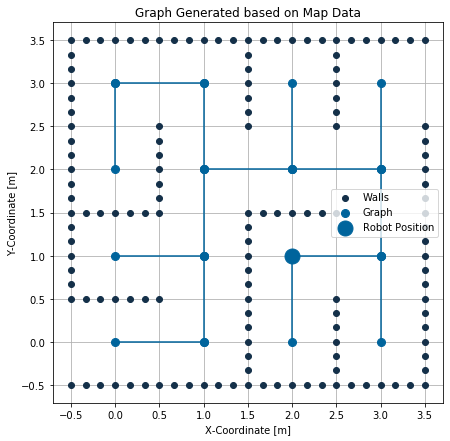

In [10]:
## Visualise maze and generated graph
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Get points on graph
nodePositions = np.array([
    fromNodeName(n["parent"], recMap) for n in edges
] + [
    fromNodeName(n["child"], recMap) for n in edges
])

nodePositions = np.unique(nodePositions, axis=1)

# Get lines connecting the nodes
edgeLines = np.array(
    [
        [
            fromNodeName(n["parent"], recMap),
            fromNodeName(n["child"], recMap)
        ] for n in edges
    ]
)

# Plot data as points (=scatterplot) and label accordingly. The colours are defined to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(nodePositions[:,1], nodePositions[:,0], c=colourScheme["twblue"], alpha=1.0, s=8**2, label="Graph")
ax.scatter([robotPos[1]], [robotPos[0]], c=colourScheme["twblue"], s=15**2, label="Robot Position")

# Plot lines connecting nodes
for line in edgeLines:
    x0, y0 = line[0]
    x1, y1 = line[1]
    x = [x0, x1]
    y = [y0, y1]
    ax.plot(x, y, c=colourScheme["twblue"])

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Graph Generated based on Map Data")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

In [11]:
# Initialize an empty dictionary for the adjacency list
graph = {}

# Create an adjacency list from the edges
graph = {}
for edge in edges:
    parent = edge['parent']
    child = edge['child']
    if parent in graph:
        graph[parent].append(child)
    else:
        graph[parent] = [child]

# DFS implementation
def DFS(graph, start_node, goal_node, path=[]):
    if start_node == goal_node: # end condition
        return path + [goal_node]
    for child in graph.get(start_node, []):
        if child not in path:  # Avoid cycles
            result_path = DFS(graph, child, goal_node, path + [start_node])
            if result_path:
                return result_path
    return None

start_node_x = (robotPos[1] - recMap.info.resolution/2 - recMap.info.origin.position.x)/recMap.info.resolution
start_node_y = (robotPos[0] - recMap.info.resolution/2 - recMap.info.origin.position.x)/recMap.info.resolution
start_node = f'{round(start_node_x)}.{round(start_node_y)}'  # Define start node

goal_node = '22.22'  # Define goal node
path = DFS(graph, start_node, goal_node)

# found_path will contain the sequence of nodes from start to goal, if a path exists
print("Found Path:", path)

Found Path: ['16.10', '22.10', '22.16', '22.22']


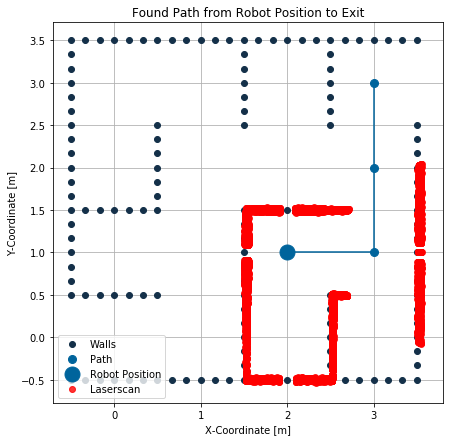

In [12]:
## Visualise maze and found path
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

## Format found path
# Get points on path
nodePositions = np.array([
    fromNodeName(n, recMap) for n in path
])

# Get lines connecting the nodes
edgeLines = np.array(
    [
        [
            fromNodeName(path[idx-1], recMap),
            fromNodeName(path[idx], recMap)
        ] for idx in range(1, len(path))
    ]
)

## Format scan
# Transform scan from robot to world coordinates
transformed_scan = transform_scan(scan, robotPos)

# Plot data as points (=scatterplot) and label accordingly. The colours are defined to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(nodePositions[:,0], nodePositions[:,1], c=colourScheme["twblue"], alpha=1.0, s=8**2, label="Path")
ax.scatter([robotPos[1]], [robotPos[0]], c=colourScheme["twblue"], s=15**2, label="Robot Position")
ax.scatter(transformed_scan[:,1], transformed_scan[:,0], c="r", alpha=0.8, label="Laserscan")

# Plot lines connecting nodes
for line in edgeLines:
    x0, y0 = line[0]
    x1, y1 = line[1]
    x = [x0, x1]
    y = [y0, y1]
    ax.plot(x, y, c=colourScheme["twblue"])

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Found Path from Robot Position to Exit")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

In [ ]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
import actionlib
from geometry_msgs.msg import PoseStamped

# initialize the actionlib client
actionClient = actionlib.SimpleActionClient('move_base', MoveBaseAction)
# wait for the actionlib client
actionClient.wait_for_server()

# create a path to be visualized in rviz and populate it with the node positions
path = Path()
path.header.stamp = rospy.Time.now()
path.header.frame_id = 'map'
for nodePos in nodePositions:
    pose = PoseStamped()
    pose.pose.position.x = nodePos[0]
    pose.pose.position.y = nodePos[1]
    path.poses.append(pose)
    
pathPub.publish(path)

# publish every node position to move_base one by one in order to drive the robot to the goal
for nodePos in nodePositions:
    goal = MoveBaseGoal()
    goal.target_pose.header.frame_id = 'map'
    goal.target_pose.pose.position.x = nodePos[0]
    goal.target_pose.pose.position.y = nodePos[1]
    goal.target_pose.pose.orientation.z = 0.72
    goal.target_pose.pose.orientation.w = 0.69
    actionClient.send_goal(goal)
    actionClient.wait_for_result()

# shut down the node
rospy.signal_shutdown('mazeEscape node shutdown')